# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'imread' from 'scipy.misc' (C:\Users\ASUS\anaconda3\lib\site-packages\scipy\misc\__init__.py)

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32
x, y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,30,2) # range(9,25)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:, 0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:, 1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:, 2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t)%batch_size!=0:
            batch_data = np.zeros((batch_size,15,x,y,3)) # (y,z) = (120,120) / (84,84) / or any other of your choice # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # RESIZE CODE
                    image = imresize(image,(120,120)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = image[:,:, 0] # normalise and feed in the image # mean of all the R channel
                    batch_data[folder,idx,:,:,1] = image[:,:, 1] #normalise and feed in the image # mean of all the G channel
                    batch_data[folder,idx,:,:,2] = image[:,:, 2] #normalise and feed in the image # mean of all the B channel
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # 20,30,40, 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#Conv3D + MaxPooling3D
model = Sequential()
model.add(Conv3D(16,(3,3,3), strides=(1,1,1),padding='same', input_shape=(15, 120,120,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32,(3,3,3), strides=(1,1,1),padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# This is all your search space, I will not interfere here
# At the end, add Flatten layer
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [7]:
# Using Transfer learning with VGG16

# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.layers import MaxPooling2D
# base = VGG16(include_top=False, weights='imagenet', input_shape=(x,y,3))
# z = base.output
# z = Flatten()(z)
# # Dropout
# features = Dense(64, activation='relu')(z)
# conv_model = Model(inputs=base.input, outputs=features)

# for l in base.layers:
#     l.trainable=False
    
# model = Sequential()
# model.add(TimeDistributed(conv_model, input_shape=(15,x,y,3)))
# model.add(BatchNormalization())

# model.add(GRU(128, return_sequences=True))
# model.add(Dropout(0.5))
# # After that, create your ANN
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(5, activation='softmax'))

In [16]:
# # Using Transfer learning with MobileNet

# from tensorflow.keras.applications.mobilenet import MobileNet

# base = MobileNet(weights='imagenet', include_top=False, input_shape=(x,y,3))

# z = base.output
# z = Flatten()(z)
# features = Dense(64, activation='relu')(z)
# conv_model = Model(inputs=base.input, outputs=features)

# for l in base.layers:
#     l.trainable=False

# model = Sequential()
# model.add(TimeDistributed(conv_model,input_shape=(15,x,y,3)))
# model.add(BatchNormalization())

# model.add(GRU(128, return_sequences=True))
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(5, activation='softmax'))

W0417 21:16:25.536871 139926059353920 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 64)            3818752   
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 64)            256       
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 128)           74496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               245888    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'
save_freq = int((num_epochs/5)*steps_per_epoch)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=save_freq)

LR = ReduceLROnPlateau(monitor='val_loss', patience=10, min_lr=0.01) #Try values for min_lr
callbacks_list = [checkpoint, LR]

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 49s 2s/step - loss: 1.5486 - categorical_accuracy: 0.3527 - val_loss: 1.6459 - val_categorical_accuracy: 0.3828 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 49s 2s/step - loss: 0.9675 - categorical_accuracy: 0.6339 - val_loss: 1.8184 - val_categorical_accuracy: 0.4609 - lr: 0.0010


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f428a4978c8>
Traceback (most recent call last):
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/mnt/disks/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


Epoch 3/30
11/21 [==============>...............] - ETA: 16s - loss: 0.5832 - categorical_accuracy: 0.7955

KeyboardInterrupt: 

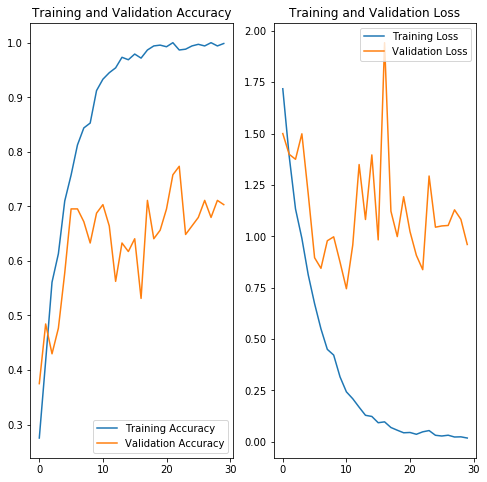

In [15]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()